In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def percent_scaling(series):
    return (series / 100)

def cpu_scaling(series):
    return (series * 4 / 100)

def single_cpu_scaling(series):
    return (((series - 100) * (-1)) / 100)

def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

k = 251

In [3]:
def preprocess_df(cpu_df):
    cpu_df['cache_hit_rate_0'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_0']) / cpu_df['cache_hit_0']
    cpu_df['cache_hit_rate_1'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_1']) / cpu_df['cache_hit_1']
    cpu_df['cache_hit_rate_2'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_2']) / cpu_df['cache_hit_2']
    cpu_df['cache_hit_rate_3'] = (cpu_df['cache_hit_0'] - cpu_df['cache_miss_3']) / cpu_df['cache_hit_3']
    
    cpu_df['br_miss_rate_0'] = cpu_df['br_miss_0'] / cpu_df['br_insns_0']
    cpu_df['br_miss_rate_1'] = cpu_df['br_miss_1'] / cpu_df['br_insns_1']
    cpu_df['br_miss_rate_2'] = cpu_df['br_miss_2'] / cpu_df['br_insns_2']
    cpu_df['br_miss_rate_3'] = cpu_df['br_miss_3'] / cpu_df['br_insns_3']
    
    cpu_df['insns_0_norm'] = cpu_df['insns_0'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['insns_1_norm'] = cpu_df['insns_1'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['insns_2_norm'] = cpu_df['insns_2'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['insns_3_norm'] = cpu_df['insns_3'] / (cpu_df['time'] - cpu_df['time'].shift())
    
    cpu_df['cycles_0_norm'] = cpu_df['cpu_cycles_0'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['cycles_1_norm'] = cpu_df['cpu_cycles_1'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['cycles_2_norm'] = cpu_df['cpu_cycles_2'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['cycles_3_norm'] = cpu_df['cpu_cycles_3'] / (cpu_df['time'] - cpu_df['time'].shift())
    
    cpu_df['bus_cycles_0_norm'] = cpu_df['bus_cycles_0'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['bus_cycles_1_norm'] = cpu_df['bus_cycles_1'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['bus_cycles_2_norm'] = cpu_df['bus_cycles_2'] / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['bus_cycles_3_norm'] = cpu_df['bus_cycles_3'] / (cpu_df['time'] - cpu_df['time'].shift())

    cpu_df['rd_ios_norm'] = cpu_df['rd_ios'] * 1000 / (cpu_df['time'] - cpu_df['time'].shift())
    cpu_df['wr_ios_norm'] = cpu_df['wr_ios'] * 1000 / (cpu_df['time'] - cpu_df['time'].shift())

    cpu_df['curr_filt'] = signal.medfilt(cpu_df['current'], kernel_size=k)
    
    cpu_df.drop(cpu_df.tail(k//2).index,inplace=True)
    cpu_df.drop(cpu_df.head(k//2).index,inplace=True)

    return cpu_df

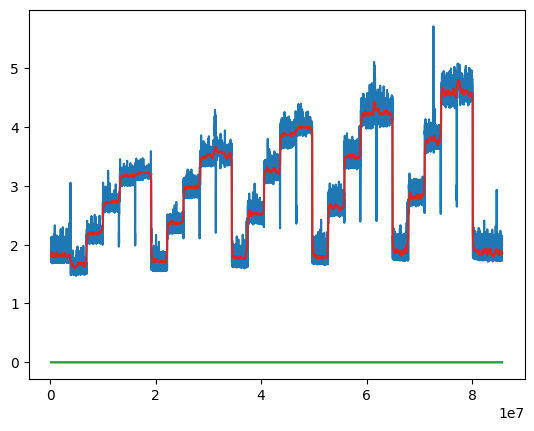

In [4]:
cpu_df = pd.read_csv('../results/numa-matrix.csv')

cpu_df['rd_ios'] = 0
cpu_df['wr_ios'] = 0

cpu_df = preprocess_df(cpu_df)

plt.plot(cpu_df['time'], cpu_df['current'])
plt.plot(cpu_df['time'], cpu_df['rd_ios_norm'])
plt.plot(cpu_df['time'], cpu_df['wr_ios_norm'])
plt.plot(cpu_df['time'], cpu_df['curr_filt'])
plt.tick_params(axis='x', which='both', top=False)

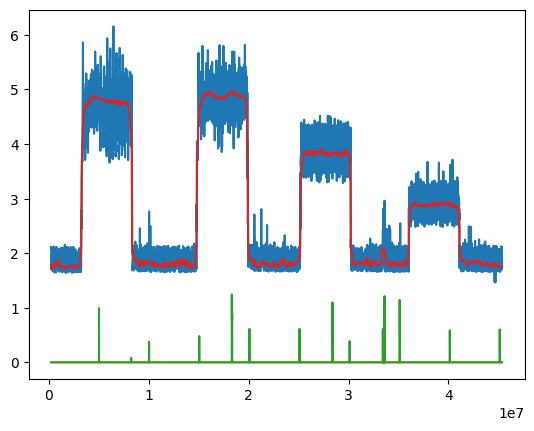

In [5]:
mem_df = pd.read_csv('../results/disk-memcpy.csv')

mem_df = preprocess_df(mem_df)

plt.plot(mem_df['time'], mem_df['current'])
plt.plot(mem_df['time'], mem_df['rd_ios_norm'])
plt.plot(mem_df['time'], mem_df['wr_ios_norm'])
plt.plot(mem_df['time'], mem_df['curr_filt'])
plt.tick_params(axis='x', which='both', top=False)

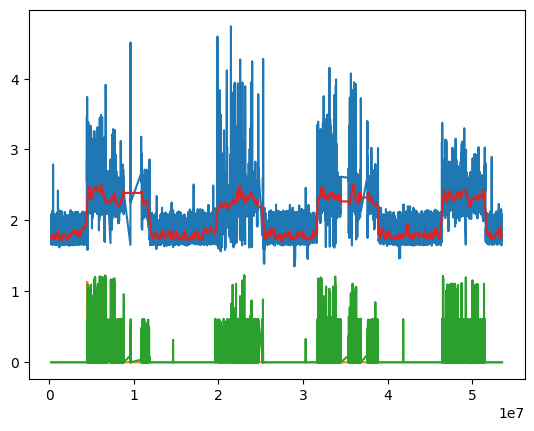

In [6]:
copy_df = pd.read_csv('../results/disk-copy.csv')

copy_df = preprocess_df(copy_df)

plt.plot(copy_df['time'], copy_df['current'])
plt.plot(copy_df['time'], copy_df['rd_ios_norm'])
plt.plot(copy_df['time'], copy_df['wr_ios_norm'])
plt.plot(copy_df['time'], copy_df['curr_filt'])
plt.tick_params(axis='x', which='both', top=False)

In [7]:
X = pd.concat([cpu_df, mem_df, copy_df])[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                                          'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                                          'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                                          'rd_ios_norm','wr_ios_norm',
                                          'freq_0', 'freq_1', 'freq_2', 'freq_3',
                                          'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y = pd.concat([cpu_df, mem_df, copy_df])['curr_filt']

In [8]:
model = RandomForestRegressor(n_estimators=500, criterion='poisson', n_jobs=8)
model.fit(X, Y)

RandomForestRegressor(criterion='poisson', n_estimators=500, n_jobs=8)

In [9]:
memrate_df = pd.read_csv('../results/disk-fft.csv')

memrate_df = preprocess_df(memrate_df)

X_test = memrate_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                     'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                     'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                     'rd_ios_norm','wr_ios_norm',
                     'freq_0', 'freq_1', 'freq_2', 'freq_3',
                     'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = memrate_df['current']
predictions = model.predict(X_test)

mean_absolute_error(Y_test, signal.medfilt(predictions, kernel_size=k))

0.24973277329052132

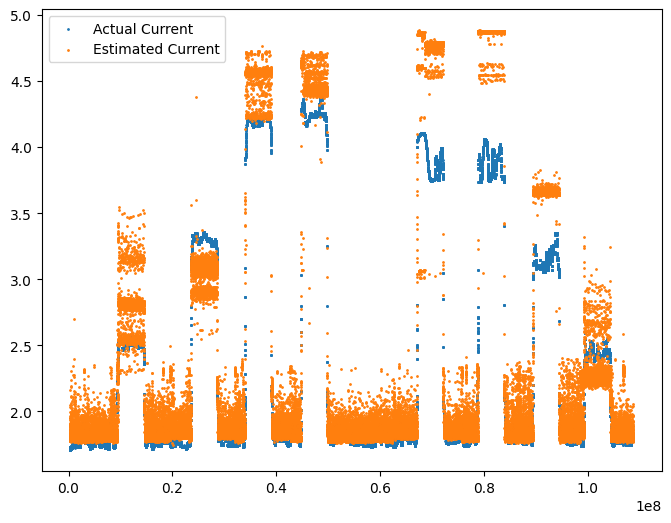

In [10]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

plt.scatter(memrate_df['time'], memrate_df['curr_filt'], label='actual', s=1)
plt.scatter(memrate_df['time'], predictions, label='predicted', s=1)
plt.legend(['Actual Current', 'Estimated Current'], loc='upper left')

In [11]:
memthrash_df = pd.read_csv('../results/disk-memthrash.csv')

memthrash_df = preprocess_df(memthrash_df)

X_test = memthrash_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                       'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                       'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                       'rd_ios_norm','wr_ios_norm',
                       'freq_0', 'freq_1', 'freq_2', 'freq_3',
                       'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = memthrash_df['current']
predictions = model.predict(X_test)

mean_absolute_error(Y_test, signal.medfilt(predictions, kernel_size=k))

0.4265435340456736

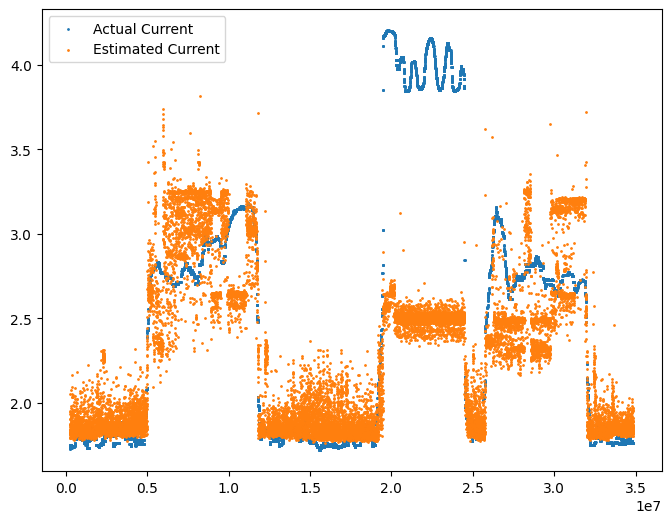

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(memthrash_df['time'], memthrash_df['curr_filt'], label='actual', s=1)
plt.scatter(memthrash_df['time'], predictions, label='predicted', s=1)
plt.legend(['Actual Current', 'Estimated Current'], loc='upper left')

In [13]:
rick_df = pd.read_csv('../results/disk-rick.csv')

rick_df = preprocess_df(rick_df)

X_test = rick_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                  'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                  'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                  'rd_ios_norm','wr_ios_norm',
                  'freq_0', 'freq_1', 'freq_2', 'freq_3',
                  'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = rick_df['current']
predictions = model.predict(X_test)

mean_absolute_error(Y_test, predictions)

0.42027101821549856

Text(0, 0.5, 'Current (Amperes)')

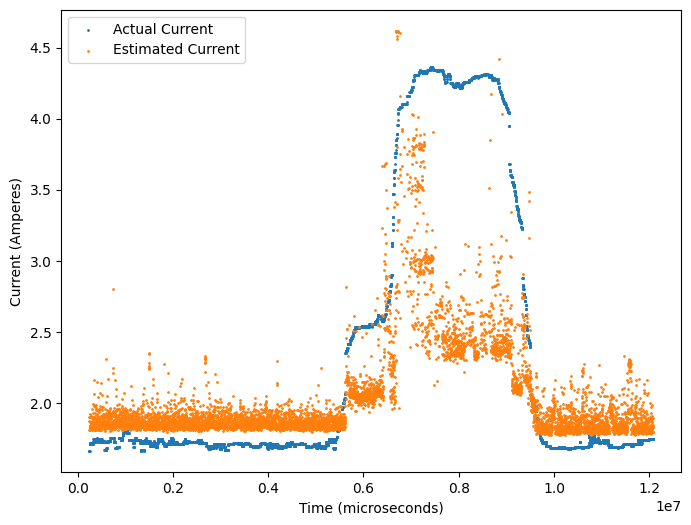

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(rick_df['time'], rick_df['curr_filt'], label='actual', s=1)
plt.scatter(rick_df['time'], predictions, label='predicted', s=1)
plt.legend(['Actual Current', 'Estimated Current'], loc='upper left')
ax.set_xlabel("Time (microseconds)")
ax.set_ylabel("Current (Amperes)")

In [ ]:
idle_df = pd.read_csv('../results/disk-idle.csv')

idle_df = preprocess_df(idle_df)

X_test = idle_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                  'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                  'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                  'rd_ios_norm','wr_ios_norm',
                  'freq_0', 'freq_1', 'freq_2', 'freq_3',
                   'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = idle_df['curr_filt']
predictions = model.predict(X_test)

mean_absolute_error(Y_test, predictions)

Text(0, 0.5, 'Current (Amperes)')

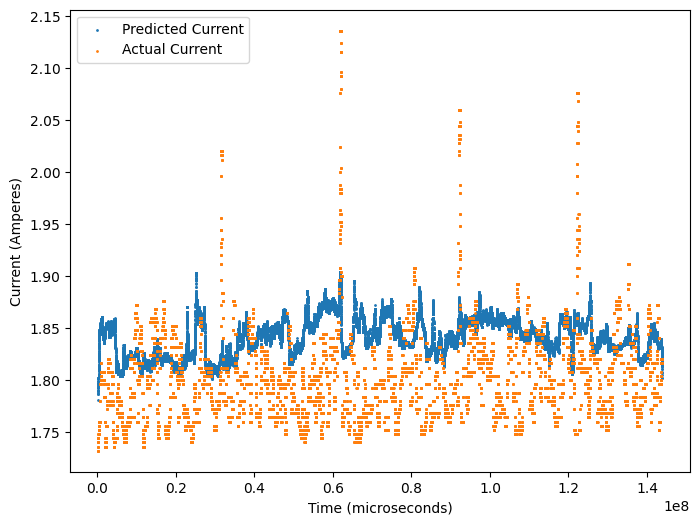

In [25]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(idle_df['time'], signal.medfilt(predictions, kernel_size=k), label='predicted', s=1)
plt.scatter(idle_df['time'], signal.medfilt(idle_df['curr_filt'], kernel_size=k), label='actual', s=1)
plt.legend(['Predicted Current', 'Actual Current'], loc='upper left')
ax.set_xlabel("Time (microseconds)")
ax.set_ylabel("Current (Amperes)")

Text(0, 0.5, 'Current (Amperes)')

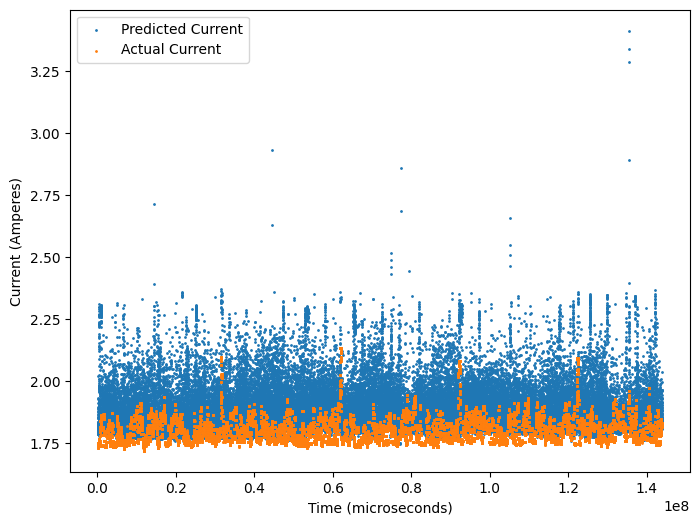

In [26]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(idle_df['time'], predictions, label='predicted', s=1)
plt.scatter(idle_df['time'], idle_df['curr_filt'], label='actual', s=1)
plt.legend(['Predicted Current', 'Actual Current'], loc='upper left')
ax.set_xlabel("Time (microseconds)")
ax.set_ylabel("Current (Amperes)")

In [33]:
latchup_df = pd.read_csv('../results/disk-idle.csv')
latchup_df.loc[50000:,'current'] += 0.08

latchup_df = preprocess_df(latchup_df)

X_test = latchup_df[['insns_0_norm', 'insns_1_norm', 'insns_2_norm', 'insns_3_norm',
                     'bus_cycles_0_norm', 'bus_cycles_1_norm', 'bus_cycles_2_norm', 'bus_cycles_3_norm',
                     'br_miss_rate_0', 'br_miss_rate_1', 'br_miss_rate_2', 'br_miss_rate_3',
                     'rd_ios_norm','wr_ios_norm',
                     'freq_0', 'freq_1', 'freq_2', 'freq_3',
                     'cache_hit_rate_0', 'cache_hit_rate_1', 'cache_hit_rate_2', 'cache_hit_rate_3']]
Y_test = latchup_df['curr_filt']
predictions = model.predict(X_test)

mean_absolute_error(latchup_df['curr_filt'], predictions)

0.07769774552348364

In [35]:
mean_absolute_error(latchup_df['curr_filt'][50000:], predictions[50000:])

0.06975352452954255

Text(0, 0.5, 'Current (Amperes)')

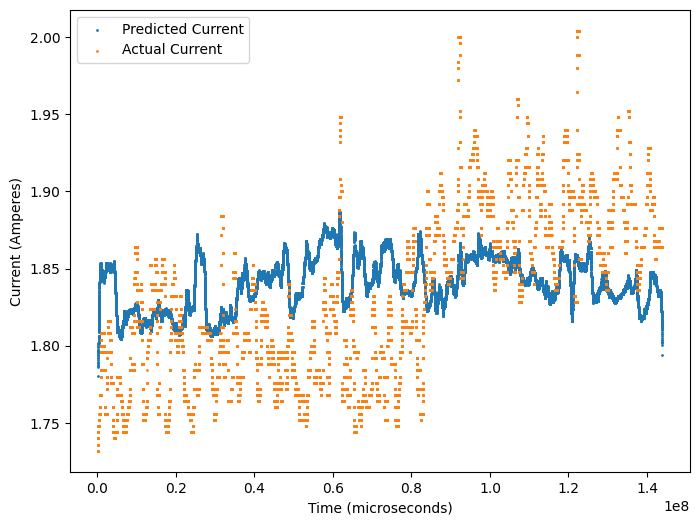

In [29]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(idle_df['time'], signal.medfilt(predictions, kernel_size=501), label='predicted', s=1)
plt.scatter(idle_df['time'], signal.medfilt(latchup_df['curr_filt'], kernel_size=501), label='actual', s=1)
plt.legend(['Predicted Current', 'Actual Current'], loc='upper left')
ax.set_xlabel("Time (microseconds)")
ax.set_ylabel("Current (Amperes)")

Text(0, 0.5, 'Current (Amperes)')

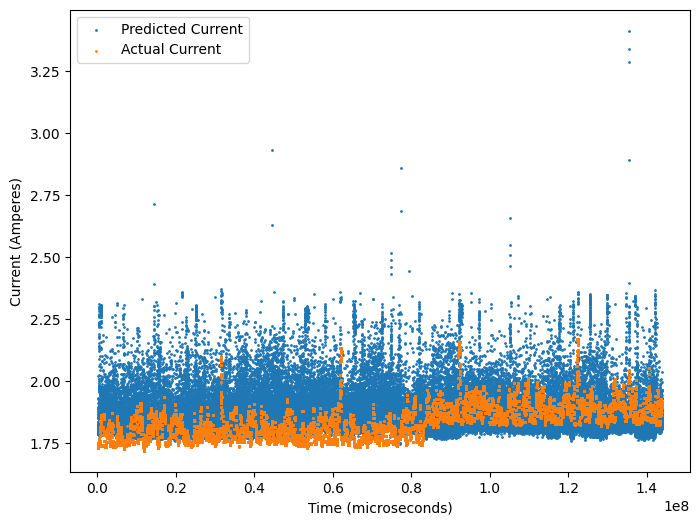

In [30]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

plt.scatter(idle_df['time'], predictions, label='predicted', s=1)
plt.scatter(idle_df['time'], latchup_df['curr_filt'], label='actual', s=1)
plt.legend(['Predicted Current', 'Actual Current'], loc='upper left')
ax.set_xlabel("Time (microseconds)")
ax.set_ylabel("Current (Amperes)")